## Import Packages

In [189]:
# !pip install folium --upgrade
# !pip install geopandas --upgrade
# !pip install beautifulsoup4 --upgrade
# !pip install plotly
# !pip install plotly nbconvert
# !pip install pandoc --upgrade
# !pip install -U scikit-learn
# !pip install nltk svgling
# !pip install datascience
!pip install gensim

In [126]:
import pandas as pd
# Import any data cleaning libraries here

# Import your selected models here

# Import any other libraries here
import numpy as np
from zipfile import ZipFile
from io import BytesIO
import urllib.request as urllib2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold



from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn import preprocessing


from sklearn import metrics
import xml.etree.cElementTree as ET  # XML parser
import requests  # make requests to web servers
import time  # will help us pause python's for loop
import json
from bs4 import BeautifulSoup
import nltk



# Dependencies
from datascience import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
import itertools
%matplotlib inline
#nltk.download('stopwords')
#nltk.download('punkt')

In [43]:
np.random.seed(0)

# Crime and Punishment Text Classifier 

## I. Classification

### A. Load and parse the trials in your date range. This will entail iterating over the files in the date range you’re interested in, parsing them with BeautifulSoup, and extracting each <div1 type="trialAccount id="...">..</div1> element.


In [141]:
import os
import glob
from bs4 import BeautifulSoup
start_yr = 1750
end_yr = 1759
trial_session_xmls = []
# trial_session_xmls = []
# xml_file = f'data/old-bailey/old-bailey-{davis_trial_id}.xml'
# xml_file = open(xml_file).read()
# davis_trial_soup = BeautifulSoup(xml_file)

for year in range(start_yr, end_yr + 1):
    for month in range(1, 13):
        for day in range(1, 32):
            file_name = f"{year}{month:02}{day:02}.xml"
            path = f"data/sessionsPapers/{file_name}"
            if os.path.exists(path):
                xml_file = open(path, "r", encoding="utf-8")
                trial_accounts = BeautifulSoup(xml_file)
                trial_session_xmls.append(trial_accounts)

C:\Users\wishw\anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


## II. Extracting features from XML:

### A. Make a DataFrame containing at least a column for the text of each trial and a column for the class label you will ultimately predict. If you have extra columns because you’re building on the Parsing XML lab code, those will be useful later!

In [142]:
def case_date(case_soup):
    for element in case_soup.body.div1.contents:
        if element.name == 'interp':
            if element.attrs['type'] == 'date':
                return element.attrs['value']
            

In [143]:
def people_in_case(case_soup):
    people = []
    for persName in case_soup.body.div1.find_all('persname'):
        person = {}
        person["type"] = persName.attrs.get("type") # `thing.get(key)` is like `thing[key]` but returns None if key is not in x instead of raising an exception
        for interp in persName.find_all('interp'):
            fieldName = interp.attrs["type"]
            fieldValue = interp.attrs["value"]
            person[fieldName] = fieldValue
        people.append(person)
    return people



In [144]:
def case_descriptions(case_soup):
    descriptions = {}
    for rs in case_soup.find_all('rs'):
        desc = {}
        for interp in rs.find_all('interp'):
            fieldName = interp.attrs["type"]
            fieldValue = interp.attrs["value"]
            desc[fieldName] = fieldValue
        desc["text"] = rs.text.strip() # myString.strip() removes the whitespace at the beginning and end of myString
        descriptions[rs.attrs['type']] = desc
    return descriptions
print("has these various descriptions in <rs> elements:\n", case_descriptions(trial_accounts))


has these various descriptions in <rs> elements:
 {'occupation': {'text': 'victualler'}, 'offenceDescription': {'offenceCategory': 'deception', 'offenceSubcategory': 'perjury', 'text': 'wilful and corrupt perjury'}, 'crimeDate': {'text': '15th of August'}, 'verdictDescription': {'verdictCategory': 'notGuilty', 'verdictSubcategory': 'noEvidence', 'text': 'Acquitted'}, 'punishmentDescription': {'punishmentCategory': 'death', 'punishmentSubcategory': 'executed', 'surname': 'Ayliffe', 'given': 'John', 'gender': 'male', 'text': 'John \n                              Ayliffe \n                           \n\n\n\n                        \n                     , capitally convicted last sessions, was executed on Monday the 19th of November.'}, 'alias': {'text': 'Castost'}}


In [145]:
import os
import glob

rows = []
for trial_accounts in trial_session_xmls:
    people = people_in_case(trial_accounts)
    #print(people)
    date = case_date(trial_accounts)
    #print(date)
    descriptions = case_descriptions(trial_accounts)
    #print(descriptions)
    row = {
            "date": date,
            "id": trial_accounts.div1.attrs["id"],
            "text": " ".join(trial_accounts.text.split()), # split on all whitespace, then join on " ", to remove long sequences of whitespace
            "any_defendant_female": False,
            "any_defendant_male": False,
            "any_victim_female": False,
            "any_victim_male": False,
        }
    if "offenceDescription" in descriptions:
        row["offenceText"] = descriptions["offenceDescription"].get("text", nan) # `dictionary.get(key, default)` is the same as `dictionary[key] if key in dictionary else default`
        row["offenceCategory"] = descriptions["offenceDescription"].get("offenceCategory", nan)
        row["offenceSubcategory"] = descriptions["offenceDescription"].get("offenceSubcategory", nan)
    if "verdictDescription" in descriptions:
        row["verdictText"] = descriptions["verdictDescription"].get("text", nan)
        row["verdictCategory"] = descriptions["verdictDescription"].get("verdictCategory", nan)
    if "punishmentDescription" in descriptions:
        row["punishmentText"] = descriptions["punishmentDescription"].get("text", nan)
        row["punishmentCategory"] = descriptions["punishmentDescription"].get("punishmentCategory", nan)
        row["punishmentSubcategory"] = descriptions["punishmentDescription"].get("punishmentSubcategory", nan)
    for person in people:
        if person.get("type") == "defendantName" and person.get("gender") == "female":
            row["any_defendant_female"] = True
        if person.get("type") == "defendantName" and person.get("gender") == "male":
            row["any_defendant_male"] = True
        if person.get("victim") == "victimName" and person.get("gender") == "female":
            row["any_victim_female"] = True
        if person.get("victim") == "victimName" and person.get("gender") == "male":
            row["any_victim_male"] = True
    rows.append(row)
df = pd.DataFrame(rows)

In [146]:
df

,date,id,text,any_defendant_female,any_defendant_male,any_victim_female,any_victim_male,offenceText,offenceCategory,offenceSubcategory,verdictText,verdictCategory,punishmentText,punishmentCategory,punishmentSubcategory
0,17500117,f17500117-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,wilful and corrupt perjury,deception,perjury,"The Prosecutor not appearing, he was acquitted",notGuilty,[Transportation. See summary.],transport,NaN
1,17500228,f17500228-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,"stealing one silver watch, val. 50 s. the good...",theft,theftFromPlace,Guilty 39 s,guilty,[Transportation. See summary.],transport,NaN
2,17500425,f17500425-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,wilful and corrupt perjury,deception,perjury,Guilty,guilty,imprisoned six months in Newgate,imprison,newgate
3,17500530,f17500530-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,"stealing one silk handkerchief , value 12 d.",theft,grandLarceny,Guilty,guilty,[Transportation. See summary.],transport,NaN
4,17500711,f17500711-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,"stealing three linen shirts, two table cloths",theft,other,Guilty,guilty,[Imprisonment. See summary.],imprison,houseOfCorrection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,17590711,f17590711-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,"Conspiracy, in sending threatning Letters to \...",theft,extortion,Acquitted,notGuilty,"capitally convicted in April Sessions, was exe...",death,executed
79,17590717,f17590717-1,"THE TRIAL OF Samuel Scrimshaw and John Ross, F...",False,False,False,False,together with \n \n ...,theft,extortion,Guilty,guilty,"stand in the Pillory twice, once at the upper ...",corporal,pillory
80,17590912,f17590912-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,deceitfully erasing the name of \n ...,deception,fraud,Brass Crosby did not appear.\nAcquitted.,notGuilty,[Transportation. See summary.],transport,NaN
81,17591024,f17591024-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,"stealing one cambric apron, value 6 d. one mus...",theft,grandLarceny,Guilty 10 d.,guilty,William \n Norman \n...,death,executed


## III. Data preparation and EDA:

### A. Preprocess the texts using techniques from class like tokenizing, stemming, and chunking. Write a couple of sentences about what you’re doing and why.

This function uses the NLTK library to tokenize the input text, remove any punctuation marks, convert all words to lowercase, remove any stop words (common words like "the", "and", etc. that are not very meaningful), and finally stems the remaining words using the Snowball Stemmer. The stems are then returned as a single string.

I can use this function to preprocess any text data before using it for further analysis, such as sentiment analysis, topic modeling, or text classification.

In [147]:
from nltk.corpus import stopwords
from string import punctuation
snowball = nltk.SnowballStemmer('english')

In [148]:
def rem_punc_stop(text):
    
    from string import punctuation
    from nltk.corpus import stopwords
    
    stop_words = set(stopwords.words("english"))
    punctuation = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punctuation])
    
    words = nltk.word_tokenize(punc_free)
    
    noise_free = [word for word in words if word not in stop_words]
    
    return noise_free

In [149]:
def does_it_all(text):
    tokens = ""
    
    not_stemmed = rem_punc_stop(text)
    stemmed = [snowball.stem(word.lower()) for word in not_stemmed]
    for word in not_stemmed:
        tokens += snowball.stem(word) + " "
    
    return tokens

In [150]:
df_tokens = df.copy()
df_tokens['tokens'] = df_tokens['text'].apply(does_it_all)
df_tokens

,date,id,text,any_defendant_female,any_defendant_male,any_victim_female,any_victim_male,offenceText,offenceCategory,offenceSubcategory,verdictText,verdictCategory,punishmentText,punishmentCategory,punishmentSubcategory,tokens
0,17500117,f17500117-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,wilful and corrupt perjury,deception,perjury,"The Prosecutor not appearing, he was acquitted",notGuilty,[Transportation. See summary.],transport,NaN,the proceed on the king commiss peac oyer term...
1,17500228,f17500228-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,"stealing one silver watch, val. 50 s. the good...",theft,theftFromPlace,Guilty 39 s,guilty,[Transportation. See summary.],transport,NaN,the proceed on the king commiss peac oyer term...
2,17500425,f17500425-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,wilful and corrupt perjury,deception,perjury,Guilty,guilty,imprisoned six months in Newgate,imprison,newgate,the proceed on the king commiss peac oyer term...
3,17500530,f17500530-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,"stealing one silk handkerchief , value 12 d.",theft,grandLarceny,Guilty,guilty,[Transportation. See summary.],transport,NaN,the proceed on the king commiss peac oyer term...
4,17500711,f17500711-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,"stealing three linen shirts, two table cloths",theft,other,Guilty,guilty,[Imprisonment. See summary.],imprison,houseOfCorrection,the proceed on the king commiss peac oyer term...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,17590711,f17590711-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,"Conspiracy, in sending threatning Letters to \...",theft,extortion,Acquitted,notGuilty,"capitally convicted in April Sessions, was exe...",death,executed,the proceed on the king commiss peac oyer term...
79,17590717,f17590717-1,"THE TRIAL OF Samuel Scrimshaw and John Ross, F...",False,False,False,False,together with \n \n ...,theft,extortion,Guilty,guilty,"stand in the Pillory twice, once at the upper ...",corporal,pillory,the trial of samuel scrimshaw john ross for a ...
80,17590912,f17590912-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,deceitfully erasing the name of \n ...,deception,fraud,Brass Crosby did not appear.\nAcquitted.,notGuilty,[Transportation. See summary.],transport,NaN,the proceed on the king commiss peac oyer term...
81,17591024,f17591024-1,THE PROCEEDINGS ON THE King's Commissions of t...,False,False,False,False,"stealing one cambric apron, value 6 d. one mus...",theft,grandLarceny,Guilty 10 d.,guilty,William \n Norman \n...,death,executed,the proceed on the king commiss peac oyer term...


### B. Separate your data into training, validation, and test sets.

In [195]:
# Training, Validation, Test Sets

# X
X = df_tokens['tokens']
tf = TfidfVectorizer(analyzer='word', 
                     ngram_range=(1,3), 
                     min_df = 0, 
                     stop_words = 'english')

tfidf_matrix =  tf.fit_transform(X)

#y

y = df_tokens['verdictCategory']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y,
                                                   train_size = .80,
                                                   test_size = .20)

# Train/Validation Split
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                           train_size = .75,
                                                           test_size = .25)

### C. Extract features to build a matrix describing just the text of the documents in the dataset. You can use featurizing methods like TF-IDF, or others, and may extend them as you see fit. Explain the assumptions of the method you’re using, and its advantages and disadvantages. Remember that the featurization is a model, and so you should treat it like fitting any other model to data (refer to the TF-IDF lab). 


In [196]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_list = df_tokens['text']

tf = TfidfVectorizer(analyzer='word', 
                     ngram_range=(1,3), 
                     min_df=0, 
                     stop_words='english')

tfidf_matrix = tf.fit_transform(text_list)

feature_names = tf.get_feature_names_out()

len(feature_names)


1302319

In [197]:
dense = tfidf_matrix.todense()
document = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(document)), document) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:20]:
    print('{0: <20} {1}'.format(phrase, score))

said                 0.22508516295793418
prisoner             0.19646096231399582
went                 0.13505109777476051
val                  0.1338364300033244
brannam              0.12663252264606967
came                 0.11676292828442836
man                  0.11394936374745418
mr                   0.10269510559955747
john                 0.09425441198863493
saw                  0.09144084745166076
house                0.09003406518317367
goods                0.0878816188825103
indicted             0.0858137183777124
did                  0.08300015384073822
took                 0.08300015384073822
indicted stealing    0.07143923764721283
stealing             0.0711815080847811
jan                  0.06670972196612357
guilty               0.06611876661889317
william              0.06330520208191899


TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a widely used technique for extracting features from text data. TF-IDF is a statistical measure that evaluates the importance of a word to a document in a collection. The idea behind this technique is to give more importance to words that occur less frequently in a document and more frequently in a collection of documents. This is because those less frequent words are likely to be more informative in distinguishing between different documents.

The TfidfVectorizer class in scikit-learn converts a collection of text documents to a matrix of TF-IDF features. The advantages of using TF-IDF include its ability to handle large datasets and its effectiveness in distinguishing between different documents. However, one of the disadvantages is that it can produce a large number of features, which can lead to the curse of dimensionality, making the feature space difficult to explore and model.

In the above code, we have used the TfidfVectorizer to extract features from the text data. We have used an analyzer as 'word', which means that we are considering the individual words as features. The ngram_range parameter is set to (1,3), which means that we are considering the individual words, as well as 2-word and 3-word combinations as features. The min_df parameter is set to 0, which means that we are considering all words, regardless of their frequency in the corpus. The stop_words parameter is set to 'english', which means that we are removing all stop words from the corpus.

We have then created a matrix of TF-IDF features using the fit_transform method of the TfidfVectorizer class. We have also obtained the feature names using the get_feature_names_out method of the TfidfVectorizer class. The resulting feature matrix has 1,302,319 features. We have printed the top 20 most important features for the first document in the dataset.

### D. Report any interesting descriptive statistics in plots and/or tables. You might report word frequencies, clustering patterns, etc. that might help with your analysis. Feel free to get creative here!

In [198]:
from collections import Counter
first_speech = X[0].split()
counter = Counter(first_speech) 
counter.most_common(20)

[('i', 520),
 ('said', 160),
 ('prison', 143),
 ('one', 104),
 ('went', 96),
 ('came', 83),
 ('man', 81),
 ('the', 78),
 ('mr', 73),
 ('see', 71),
 ('good', 68),
 ('john', 66),
 ('saw', 65),
 ('indict', 62),
 ('val', 61),
 ('took', 59),
 ('go', 58),
 ('hous', 57),
 ('steal', 55),
 ('william', 50)]

In [199]:
df_cluster = df_tokens[['offenceCategory', 'tokens']]
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


vectorizer = CountVectorizer()
X_n = vectorizer.fit_transform(df_cluster['tokens'])

kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(X_n)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_n.toarray())

C:\Users\wishw\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [200]:
print(np.unique(labels))

[0 1 2 3 4]


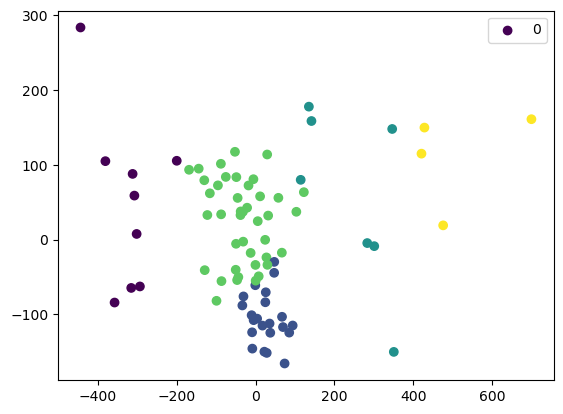

In [201]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)

# Add the legend
plt.legend(np.unique(labels))

The resulting plot is a scatter plot where each point represents an offence category in the dataset, and the color of the point indicates the cluster to which it has been assigned. The goal of clustering in this case is to group similar offence categories together based on their token frequencies.

Points that are close together indicate offence categories with similar token frequency patterns. For example, if you see a group of points clustered together, it means that the offence categories represented by those points have similar token frequencies, and are likely to be related to each other in some way.

Points that are far apart indicate offence categories with dissimilar token frequency patterns. For example, if you see points scattered far apart from each other, it means that the offence categories represented by those points have different token frequency patterns, and are likely to be unrelated to each other.

The colors of the points represent the clusters to which they have been assigned. The group of points with the same color means that they belong to the same cluster, and are likely to be similar in some way.

Overall, the plot can be used to gain insights into the relationships between different offence categories based on their token frequencies, and to identify patterns and clusters within the data.

## IV. Classification

### A. Write a metrics function which takes an array of predicted labels and one of true labels and reports how the predictions perform. It should report the accuracy (what percent were correct?), but also false positive rate and false negative rate. If you are classifying into more than 2 classes, rather than false positive/negative rates, display a confusion matrix.

In [202]:
def classification_metrics(y_pred, y_true):
    n = len(y_pred)
    accuracy = sum(y_pred == y_true) / n
    fp = sum((y_pred == 1) & (y_true == 0)) / sum(y_true == 0)
    fn = sum((y_pred == 0) & (y_true == 1)) / sum(y_true == 1)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"False Positive Rate: {fp:.3f}")
    print(f"False Negative Rate: {fn:.3f}")


### B. Why does it matter to look not just at the accuracy, but also at the FPR/FNR/confusion matrix?

While accuracy is a common metric to evaluate a classifier, it may not always provide the full picture of how well the model is performing. In some cases, it is important to look beyond accuracy and analyze the confusion matrix, which is a table showing how many instances were classified correctly or incorrectly. From the confusion matrix, we can calculate the False Positive Rate (FPR) and False Negative Rate (FNR).

False Positive Rate (FPR) is the proportion of actual negative instances that are predicted as positive. False negatives, on the other hand, are actual positives that are predicted as negative. False positives and false negatives can have different costs or implications, depending on the problem at hand. For example, in the case of a medical diagnosis, a false negative (a person with a disease is incorrectly diagnosed as not having it) could be more harmful than a false positive (a healthy person is diagnosed with a disease).

Therefore, analyzing the FPR and FNR in addition to accuracy can give a more complete understanding of the classifier's performance and help in making informed decisions on whether the model needs further optimization or not.

### III. Train three classifiers—a linear SVM, a logistic regression, and at least one more of your choosing—on the training data, and then show how each performs on the validation set (compute metrics).
Note: When using a logistic regression, or other similar classifiers, note the option of passing the class_weight parameter (particularly class_weight="balanced"). To understand its utility, imagine you are writing a classifier to determine if someone has a rare disease. If the disease is sufficiently rare, a classifier with a 99.5% accuracy may be one that always says the patient is negative! When you really care about noticing rare classes (like guilty verdicts), it is a good idea to weight the model to avoid misclassifying those rare classes. This will help you rein in your false negative/positive rates.


In [203]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train linear SVM
svm_clf = LinearSVC()
svm_clf.fit(X_train, y_train)

# Evaluate on validation set
y_pred_svm = svm_clf.predict(X_validate)
acc_svm = accuracy_score(y_validate, y_pred_svm)
cm_svm = confusion_matrix(y_validate, y_pred_svm)
cr_svm = classification_report(y_validate, y_pred_svm)

# Train logistic regression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

# Evaluate on validation set
y_pred_lr = lr_clf.predict(X_validate)
acc_lr = accuracy_score(y_validate, y_pred_lr)
cm_lr = confusion_matrix(y_validate, y_pred_lr)
cr_lr = classification_report(y_validate, y_pred_lr)

# Train random forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Evaluate on validation set
y_pred_rf = rf_clf.predict(X_validate)
acc_rf = accuracy_score(y_validate, y_pred_rf)
cm_rf = confusion_matrix(y_validate, y_pred_rf)
cr_rf = classification_report(y_validate, y_pred_rf)

# Print metrics
print("Linear SVM:")
print("Accuracy:", acc_svm)
print("Confusion Matrix:")
print(cm_svm)
print("Classification Report:")
print(cr_svm)
print()

print("Logistic Regression:")
print("Accuracy:", acc_lr)
print("Confusion Matrix:")
print(cm_lr)
print("Classification Report:")
print(cr_lr)
print()

print("Random Forest:")
print("Accuracy:", acc_rf)
print("Confusion Matrix:")
print(cm_rf)
print("Classification Report:")
print(cr_rf)
print()


C:\Users\wishw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wishw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wishw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wishw\anaconda3\lib\site-packages\sklearn\metr

Linear SVM:
Accuracy: 0.705882352941
Confusion Matrix:
[[ 0  5]
 [ 0 12]]
Classification Report:
              precision    recall  f1-score   support

      guilty       0.00      0.00      0.00         5
   notGuilty       0.71      1.00      0.83        12

    accuracy                           0.71        17
   macro avg       0.35      0.50      0.41        17
weighted avg       0.50      0.71      0.58        17


Logistic Regression:
Accuracy: 0.705882352941
Confusion Matrix:
[[ 0  5]
 [ 0 12]]
Classification Report:
              precision    recall  f1-score   support

      guilty       0.00      0.00      0.00         5
   notGuilty       0.71      1.00      0.83        12

    accuracy                           0.71        17
   macro avg       0.35      0.50      0.41        17
weighted avg       0.50      0.71      0.58        17


Random Forest:
Accuracy: 0.705882352941
Confusion Matrix:
[[ 0  5]
 [ 0 12]]
Classification Report:
              precision    recall  f1-sco

C:\Users\wishw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wishw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wishw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
